<a href="https://colab.research.google.com/github/Ani7700/Rainfall-Forecast/blob/main/Rainfall_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset:

In [3]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()
full_data.shape
full_data.info()
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Saving weatherAUS.csv to weatherAUS (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null

# Data visualization & pre-processing

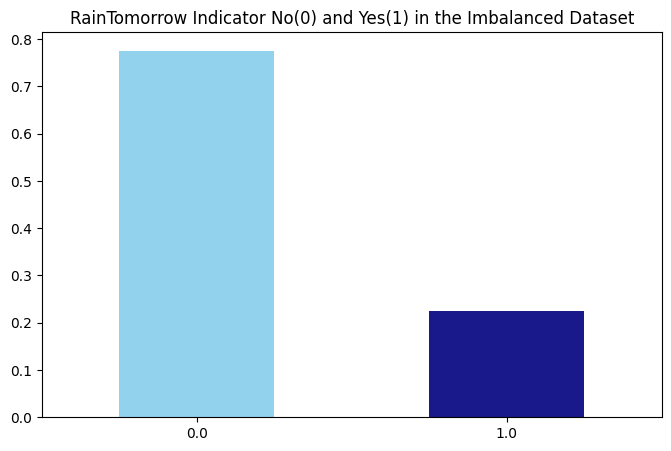

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

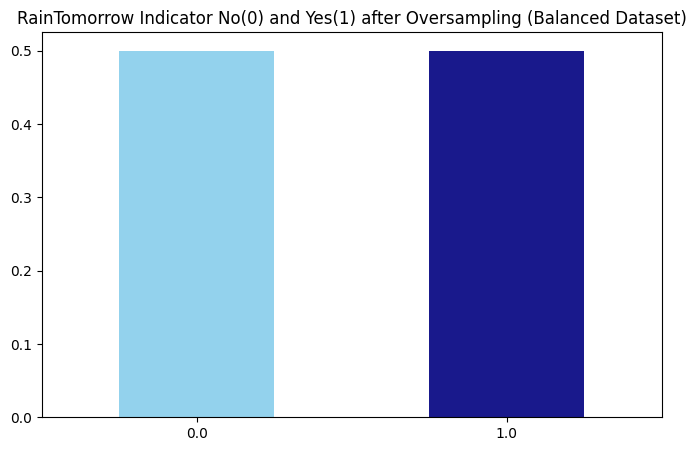

In [5]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

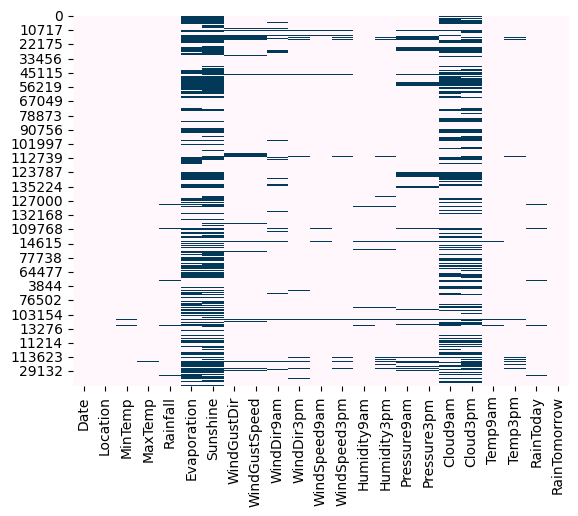

In [6]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)
oversampled.select_dtypes(include=['object']).columns

In [7]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [8]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


(170669, 23)

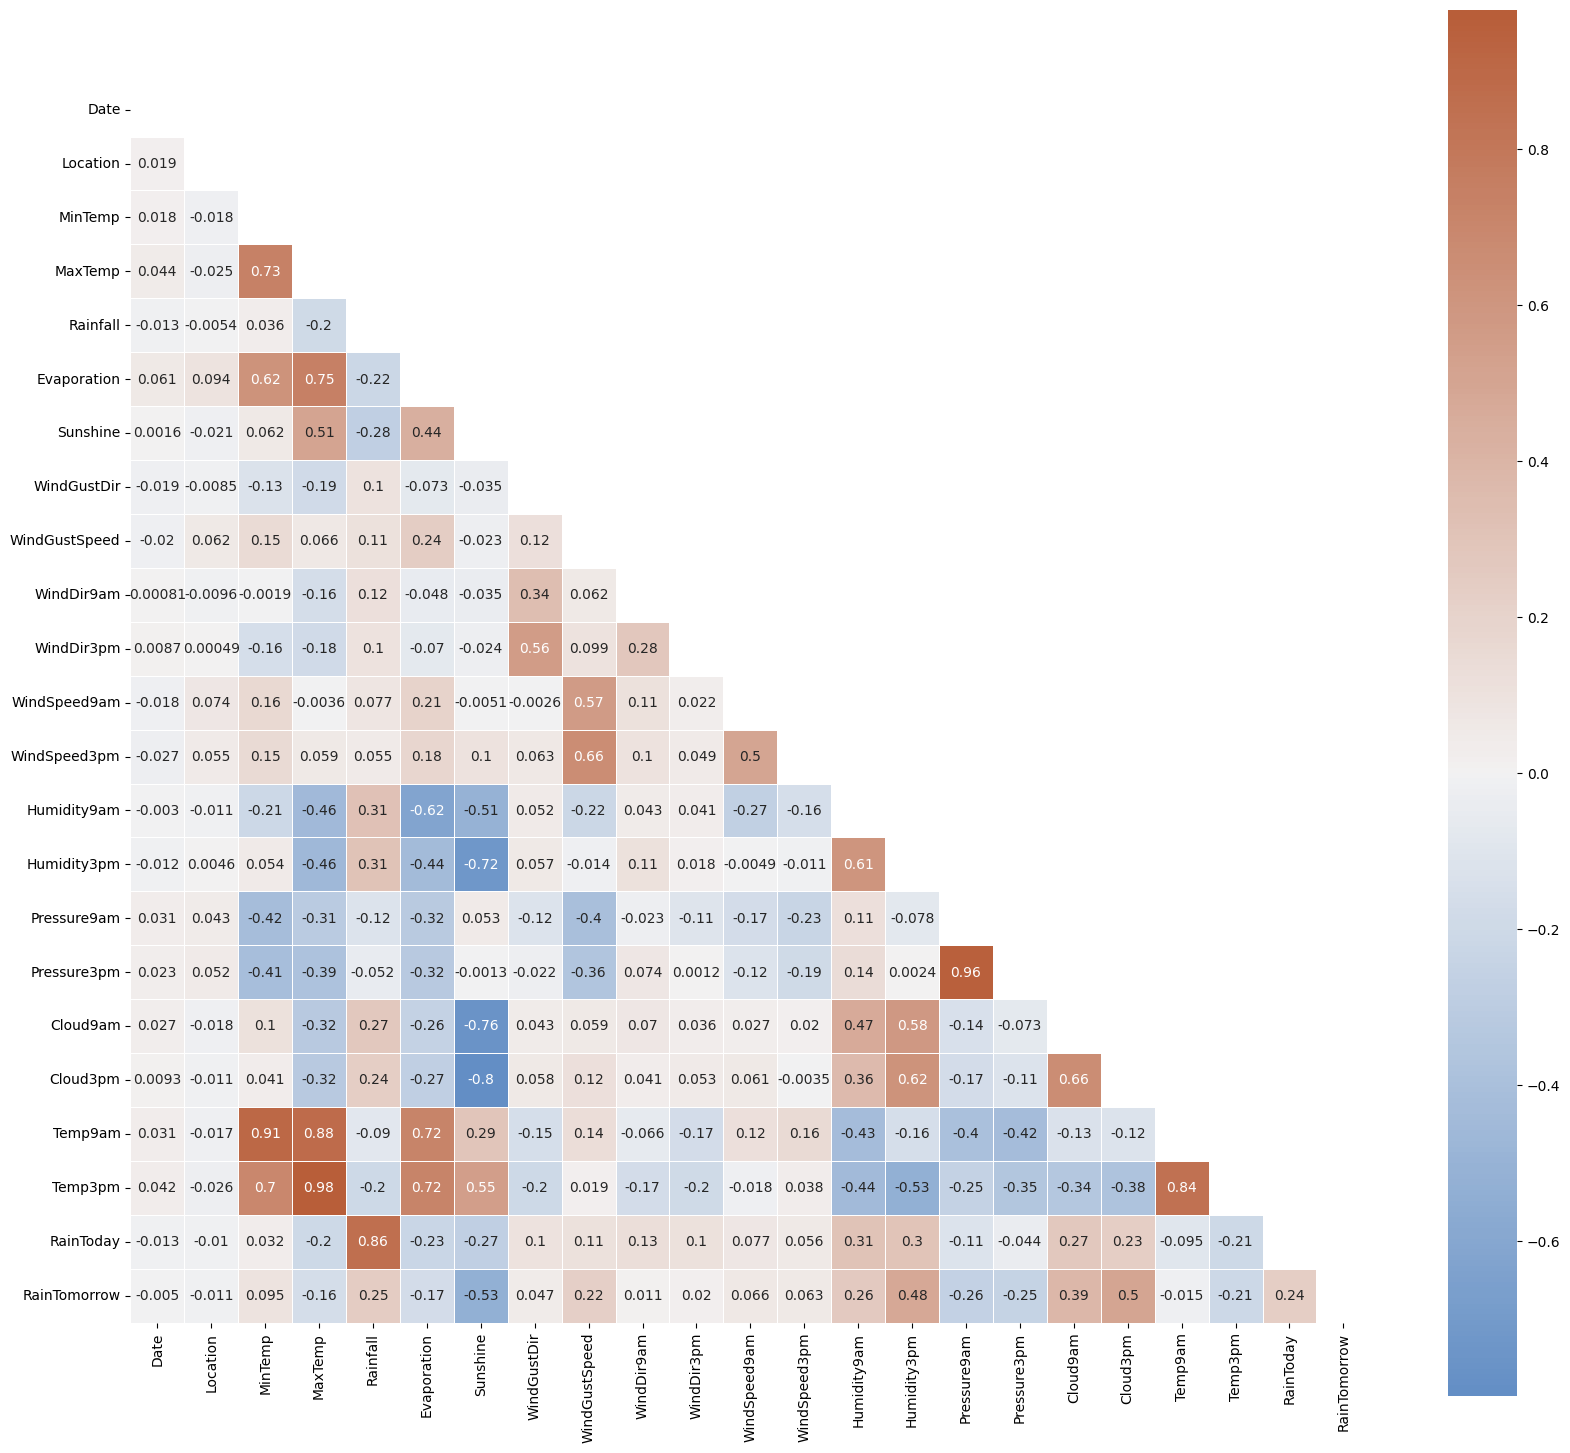

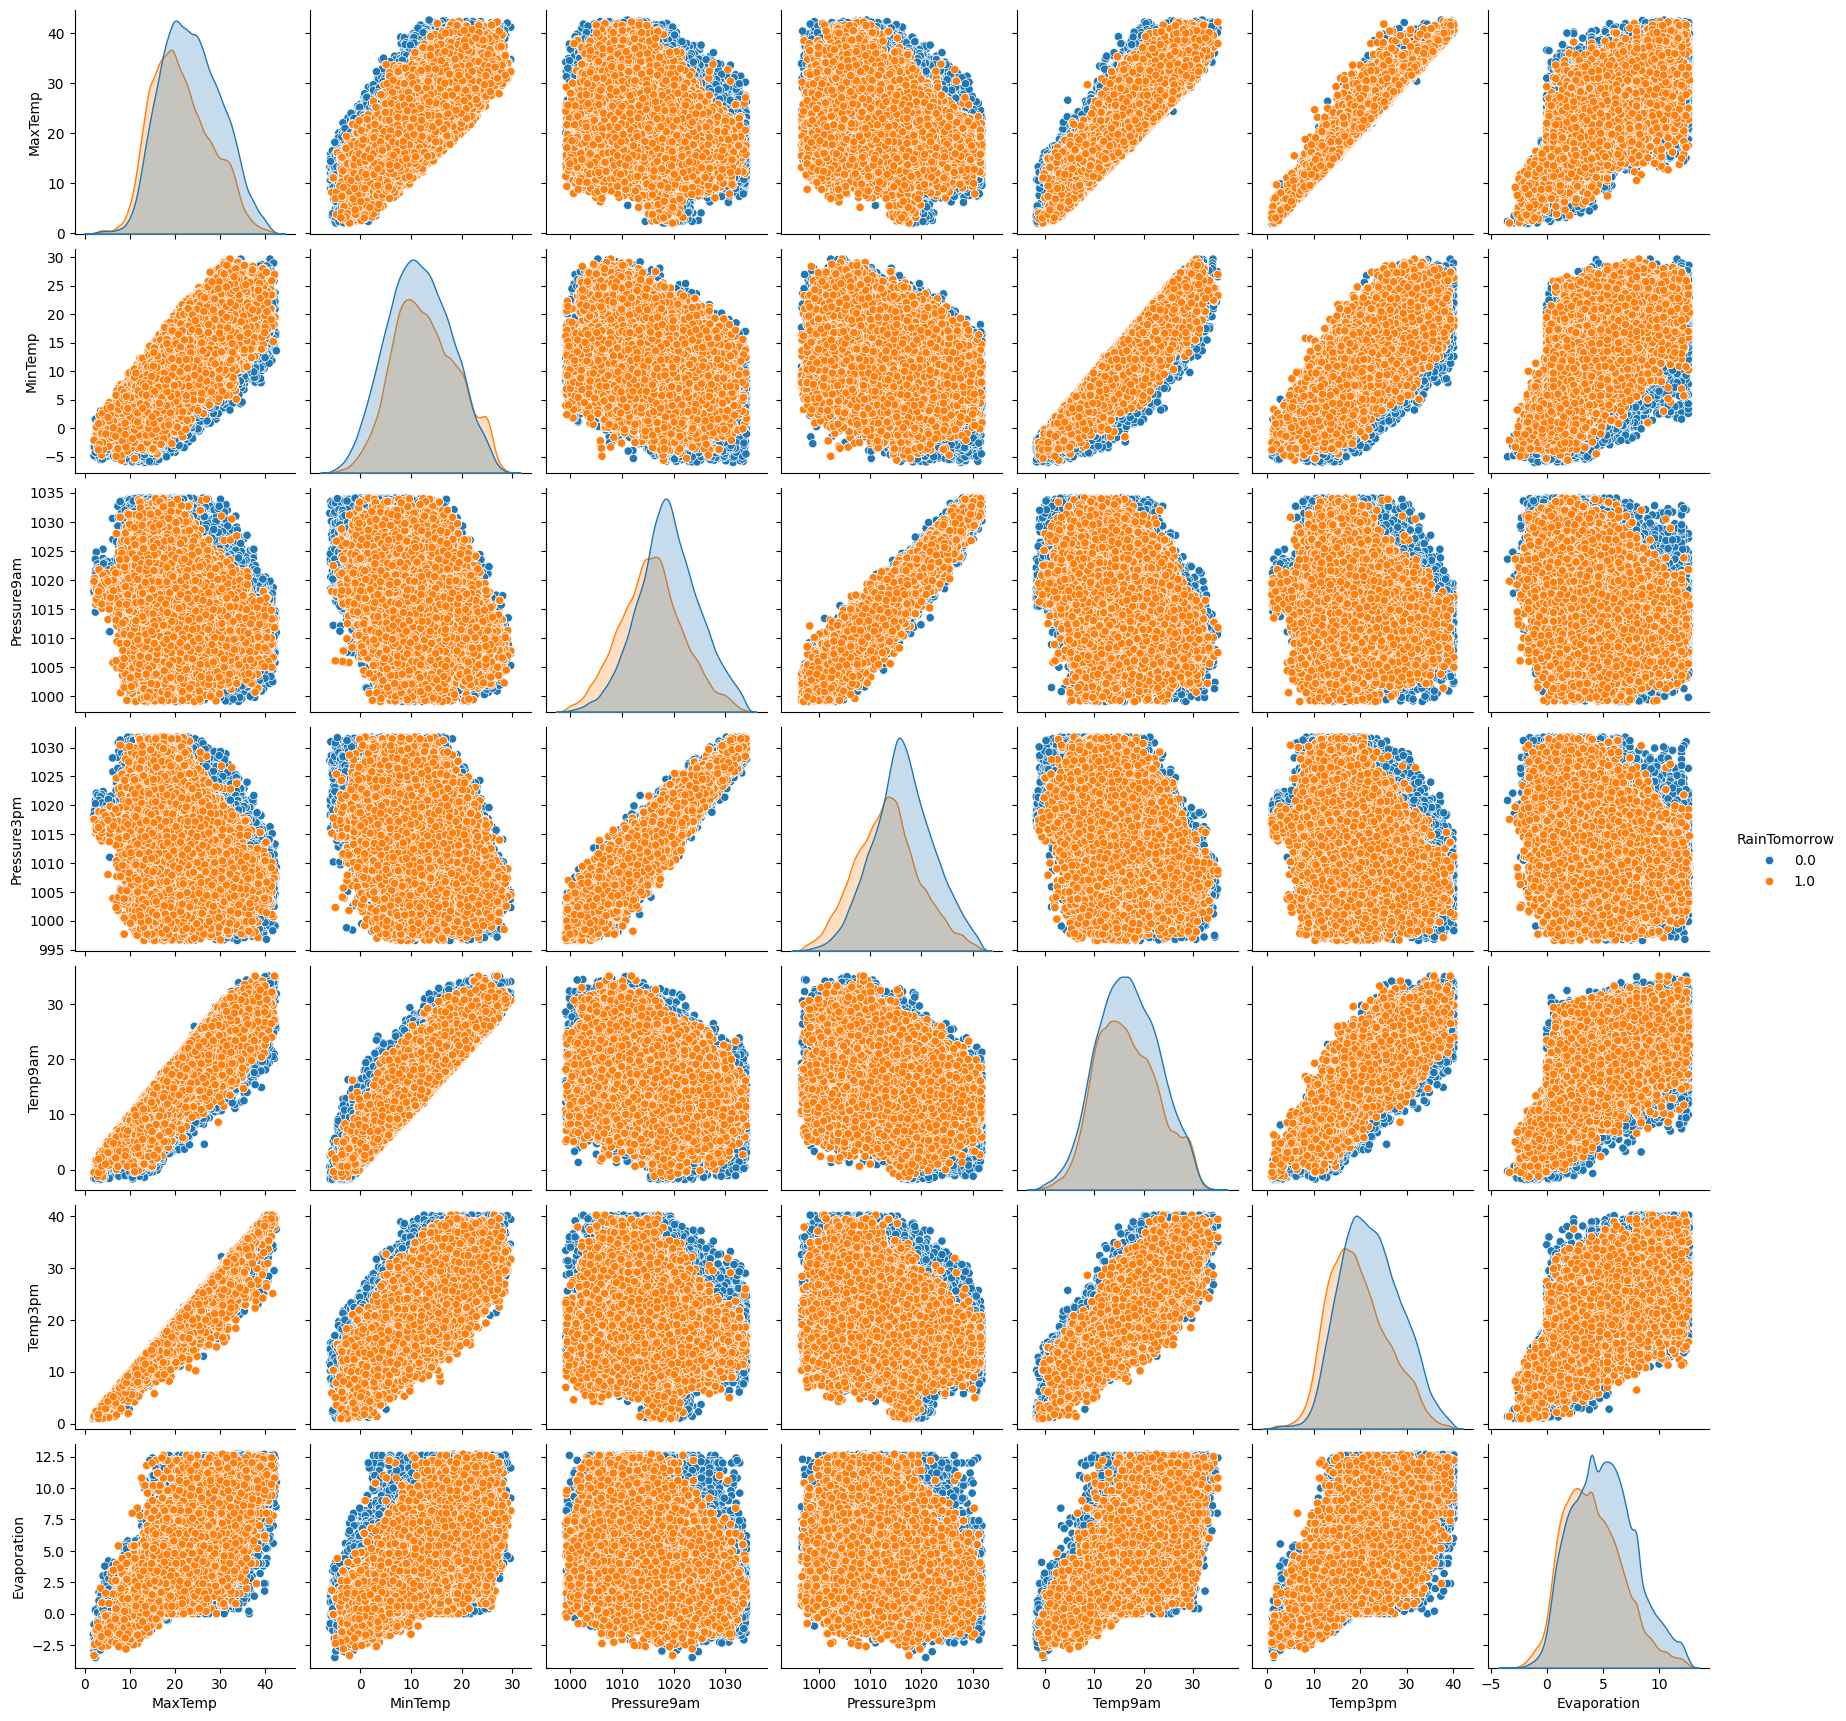

In [11]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

In [12]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [13]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


In [15]:
# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [16]:
# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Models

## Helper functions:

There are 2 helper functions:
</br>
1. plot_confusion_matrix: Plot confusion matrix based on predicted result:
2. run model: Run model prediction and generate evaluation metrics: accuracy, roc_auc, coh_kap and time_taken.

In [17]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize=None):
    # 计算混淆矩阵
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize=normalize)

    # 创建混淆矩阵对象
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # 绘制混淆矩阵
    disp.plot(cmap=cmap)
    plt.show()

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')

    return model, accuracy, roc_auc, coh_kap, time_taken

## Model1: Logistic Regression:

Accuracy = 0.7953267085403581
ROC Area under Curve = 0.7896010097174797
Cohen's Kappa = 0.5824298159462458
Time taken = 2.379584789276123
              precision    recall  f1-score   support

         0.0    0.80467   0.83760   0.82081     23879
         1.0    0.78228   0.74160   0.76140     18789

    accuracy                        0.79533     42668
   macro avg    0.79348   0.78960   0.79110     42668
weighted avg    0.79481   0.79533   0.79465     42668



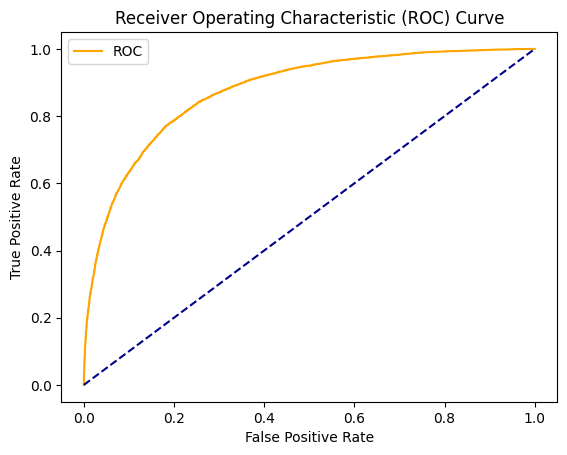

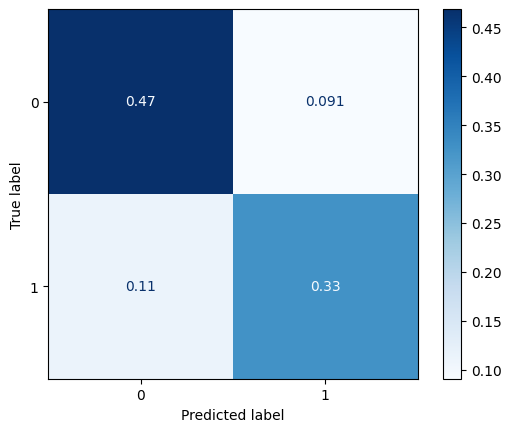

In [18]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)



## Model2: Decision Tree

Accuracy = 0.8743086153557701
ROC Area under Curve = 0.8743461407968565
Cohen's Kappa = 0.7459292946709778
Time taken = 0.6167809963226318
              precision    recall  f1-score   support

         0.0    0.89861   0.87403   0.88615     23879
         1.0    0.84528   0.87466   0.85972     18789

    accuracy                        0.87431     42668
   macro avg    0.87194   0.87435   0.87293     42668
weighted avg    0.87512   0.87431   0.87451     42668



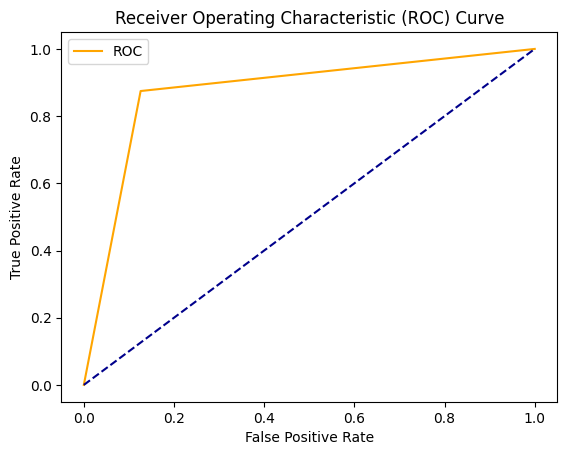

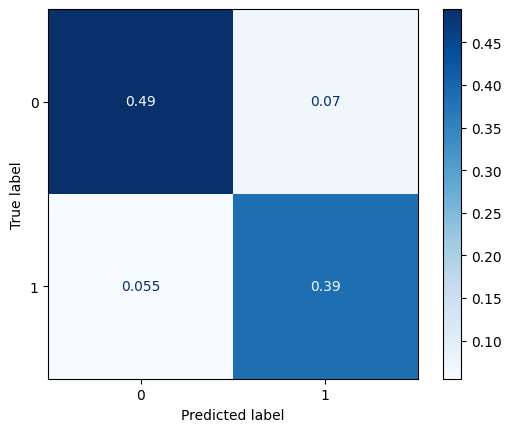

In [19]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 50,
        'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

## Model3: Random Forest

Accuracy = 0.9520249367207275
ROC Area under Curve = 0.9537800015219011
Cohen's Kappa = 0.9031388727309624
Time taken = 42.01846480369568
              precision    recall  f1-score   support

         0.0    0.97428   0.93907   0.95635     23879
         1.0    0.92596   0.96849   0.94675     18789

    accuracy                        0.95202     42668
   macro avg    0.95012   0.95378   0.95155     42668
weighted avg    0.95300   0.95202   0.95212     42668



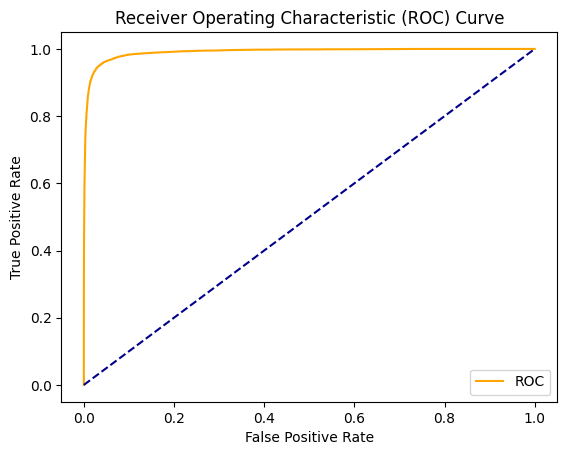

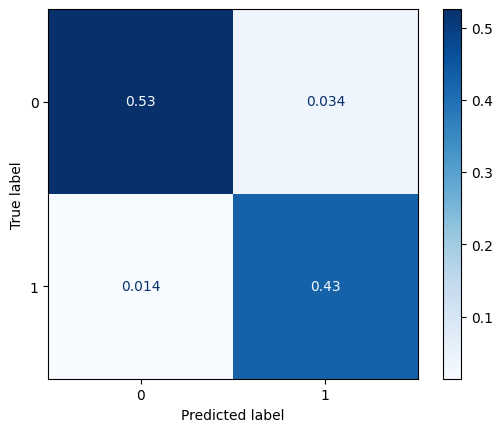

In [20]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 50,
             'min_samples_leaf': 1,
             'min_samples_split': 3,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

## Model4: KNN

Accuracy = 0.8719180650604669
ROC Area under Curve = 0.8765894772255899
Cohen's Kappa = 0.7434832769736561
Time taken = 40.1655650138855
              precision    recall  f1-score   support

         0.0    0.92665   0.83743   0.87978     23879
         1.0    0.81591   0.91575   0.86295     18789

    accuracy                        0.87192     42668
   macro avg    0.87128   0.87659   0.87137     42668
weighted avg    0.87788   0.87192   0.87237     42668



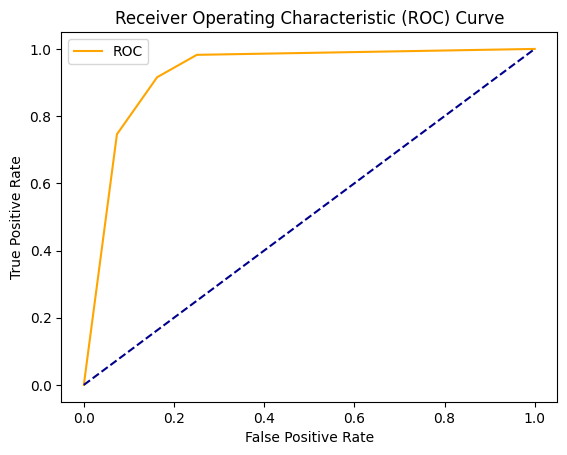

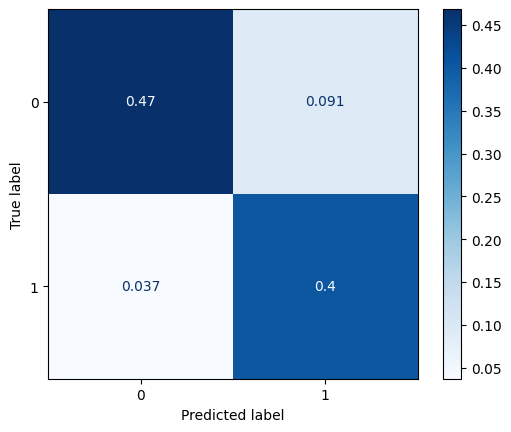

In [45]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

params_knn = {
    'n_neighbors': 3,  # Number of neighbors to consider
    'weights': 'uniform',  # Uniform weights for all neighbors
    'algorithm': 'auto'  # Algorithm used to compute the nearest neighbors
}

model_knn = KNeighborsClassifier(**params_knn)
model_knn, accuracy_knn, roc_auc_knn, coh_kap_knn, tt_knn = run_model(model_knn, X_train, y_train, X_test, y_test)

## Model5: adaboost

Accuracy = 0.7823193025217962
ROC Area under Curve = 0.7662720558227314
Cohen's Kappa = 0.5466529439877432
Time taken = 115.64693570137024
              precision    recall  f1-score   support

         0.0    0.75662   0.90079   0.82244     23879
         1.0    0.83363   0.63175   0.71878     18789

    accuracy                        0.78232     42668
   macro avg    0.79512   0.76627   0.77061     42668
weighted avg    0.79053   0.78232   0.77679     42668



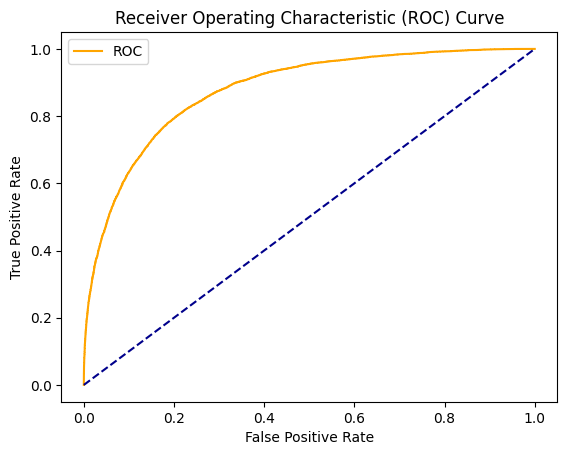

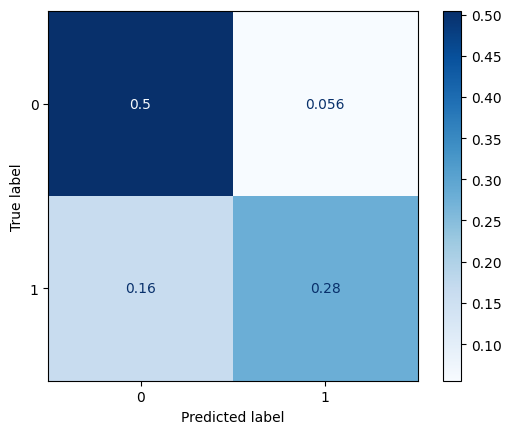

In [44]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier

params_ada = {
    'n_estimators': 500,  # Number of weak learners to train iteratively
    'learning_rate': 1.0  # Weight applied to each weak learner
}
model_ada = AdaBoostClassifier(**params_ada)
model_ada, accuracy_ada, roc_auc_ada, coh_kap_ada, tt_ada = run_model(model_ada, X_train, y_train, X_test, y_test)

# Evaluation:
Compare all models and generate evaluation metrics report

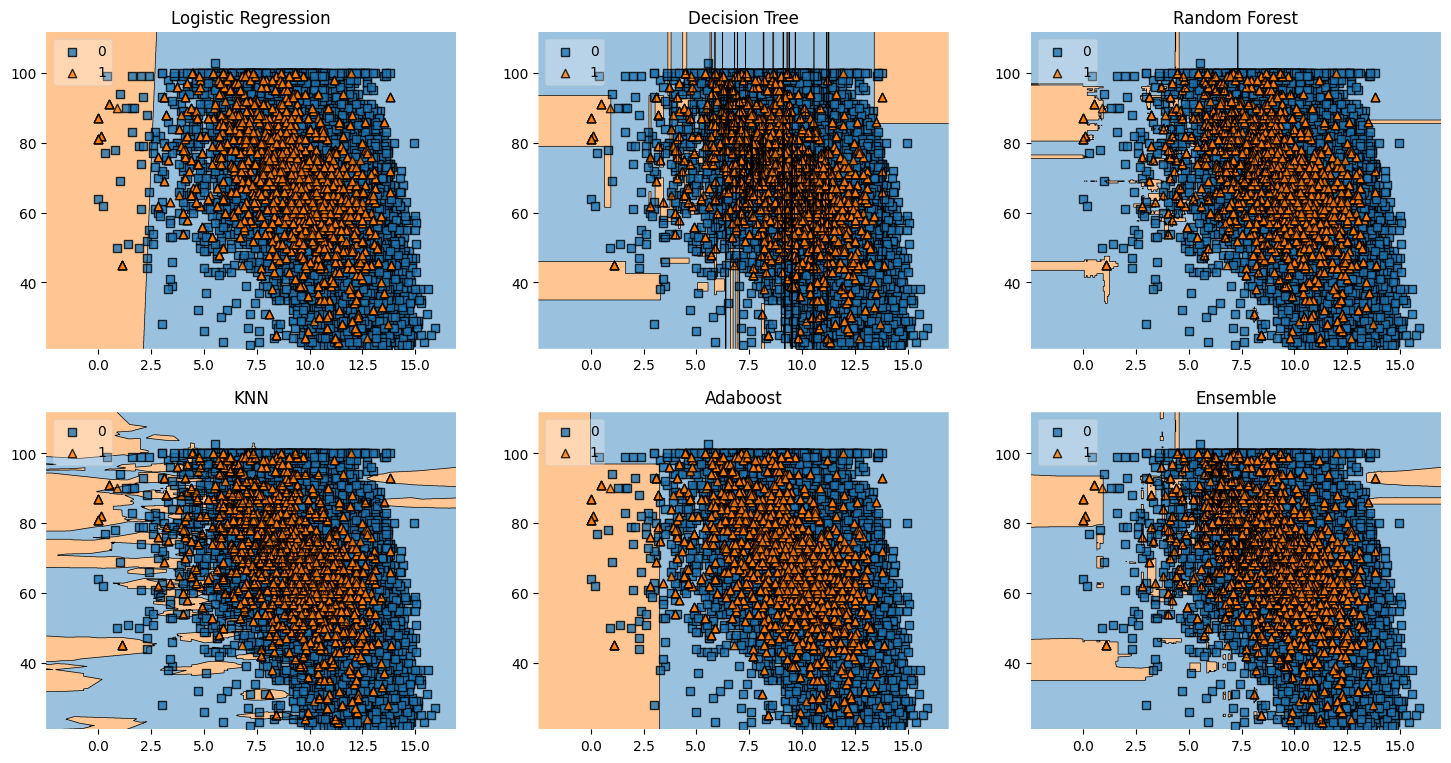

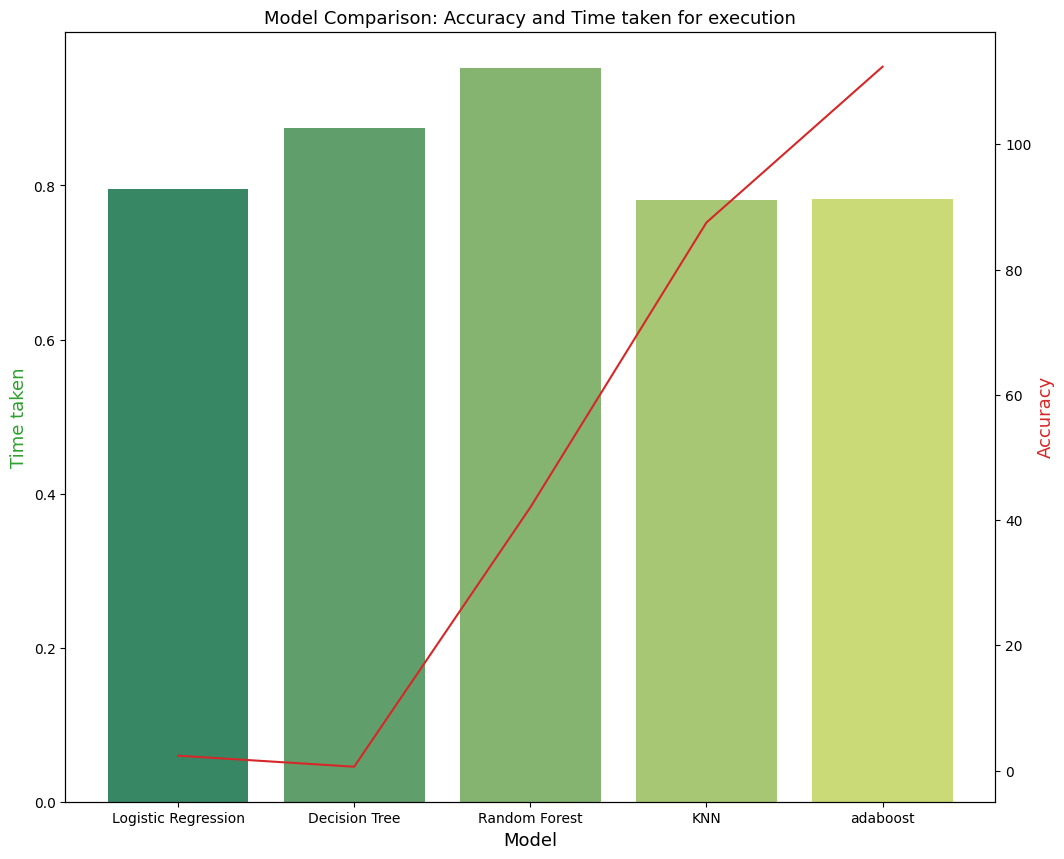

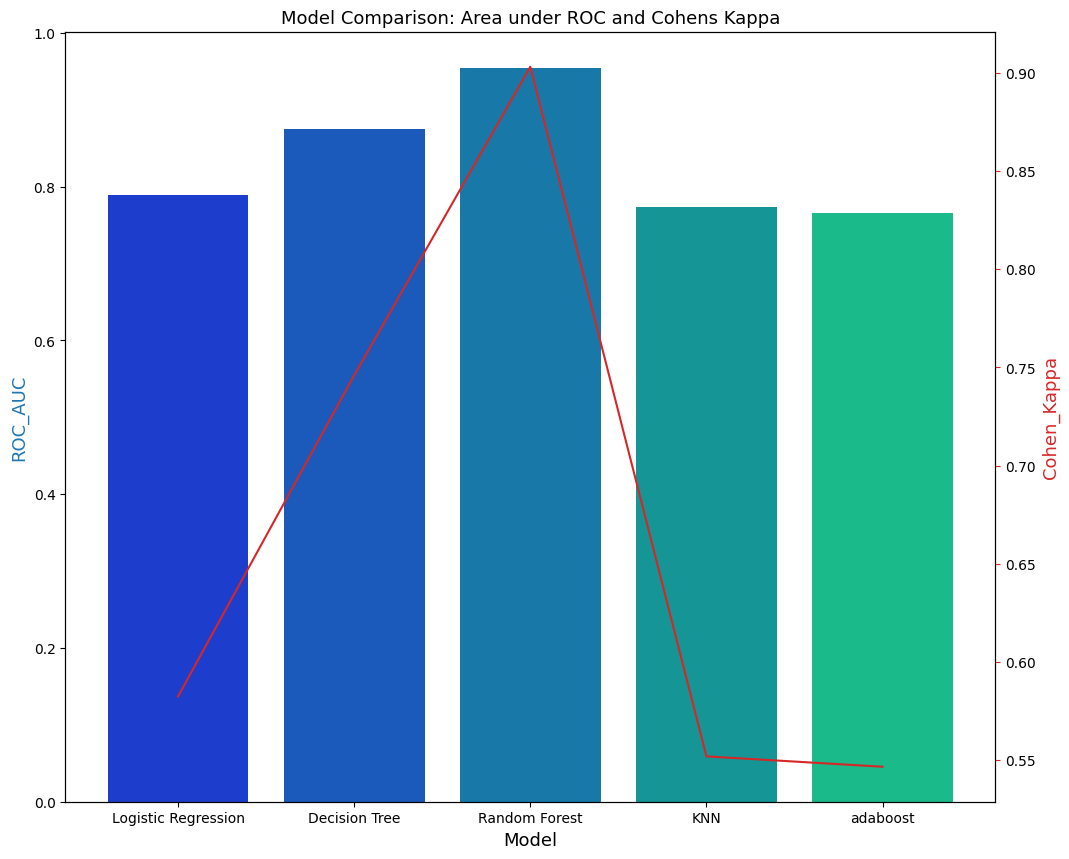

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345)
clf3 = RandomForestClassifier(random_state=12345)
clf4 = KNeighborsClassifier()
clf5 = AdaBoostClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf2, clf3, clf4, clf5], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Random Forest',
          'KNN',
          'Adaboost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X,y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf,
                                filler_feature_values={2: value},
                                filler_feature_ranges={2: width},
                                legend=2)
    plt.title(lab)

plt.show()
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_knn, accuracy_ada]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_knn, roc_auc_ada]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_rf, coh_kap_knn, coh_kap_ada]
tt = [tt_lr, tt_dt, tt_rf, tt_knn, tt_ada]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest', 'KNN','adaboost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Accuracy', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Time taken', data = data, sort=False, color=color)
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()